Plotting / Data Visualization
==

In the sciences we measure things.  Data visualization tools are critical to understanding and presenting our results.  This notebook and the accompanying code in the repository will review a number of common plotting tasks.  Gnuplot is handy for quick plotting of functions or to display tabulated data, but we will often want to include plot making into our own programs. This this is possible with Gnuplot, better options exist.  Two tools will be presented (1) the common Python [Matplotlib](https://matplotlib.org/) package and (2) the [ROOT](https://root.cern.ch/) data analysis framework which has common APIs for both C++ and Python ([PyROOT](https://root.cern/manual/python/)).  In the Physx6x0 classes you can generally use whatever tools you prefer which may be influenced by your research group's tools and personal preferences.  However, be careful not to limit yourself artifically and keep an open mind to try new tools to find the best one for the job.  It's always a good thing to have more [tools](https://www.explainxkcd.com/wiki/index.php/2510:_Modern_Tools)!

Before we begin here's a quick, very personal, view of the more generic Python approach versus using a dedicated analysis framework like ROOT.  Of course any number of tools can be combined when building your analysis workflows.  It's a "yes, and?" not and "either-or" situation.

|  | Common Pythonverse | ROOT Framework |
| --- | --- | --- |
| Python compatibility | obviously! | yes |
| C++ compatibility | WIP | yes |
| C/C++ bridging | ctypes/cppyy | internal cppyy | 
| ease of C++<=>Python data passing | good | very good |
| Plotting | matplotlib | built in |
| Data analysis integrated w/ plots | no | yes |
| Special functions| scipy.special | built in |
| minimizers/optimization | scipy.optimize | built in |
| highly configurable fits| iminuit | built in minuit(2)/roofit |
| integration/ode | scipy.integrate | built in / GSL or Boost |
| statistical analysis | scipy.stats | built in |
| data wrangling | pandas / numpy / uproot | built in () |
| standardization of interfaces | meh | very good |
| stability of interfaces | improving | very good |

Import the python interfaces.

In [1]:
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt
import random

Welcome to JupyROOT 6.28/04


Simple Graphs
===

We begin with a simple graph in Matplotlib using the [plot method](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html).

In [2]:
# Generate some random data with associated error bars.
x=np.arange(10,17,0.3)
y=x.copy()+np.random.rand(len(x))
yerr=np.abs(np.random.rand(len(x)))*0.5+0.1

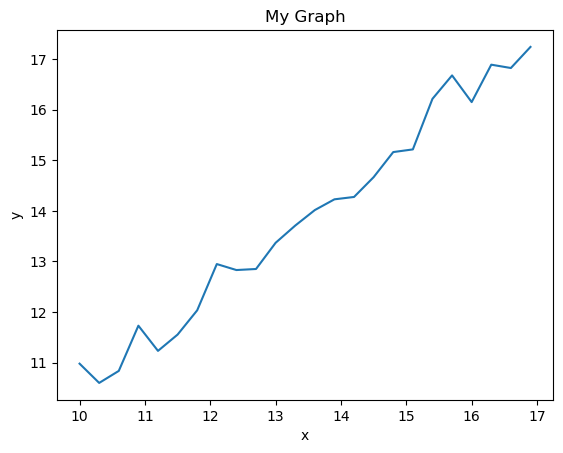

In [3]:
plt.title('My Graph')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x,y);    # why do I use the optional ; here?

The equivalent graph using in ROOT using its Python interface (PyROOT). 

See [TGraph documentation](https://root.cern.ch/doc/master/classTGraph.html) for Drawing options.  Here PyROOT is able to interpted the numpy arrays.  The reason we specify the length is that numpy arrays are not standard C++ opbjects.  The PyROOT interfaces is acessing the the location data stored in the computer memory.  The length parameter tells the C++ code how much data to read from that address.

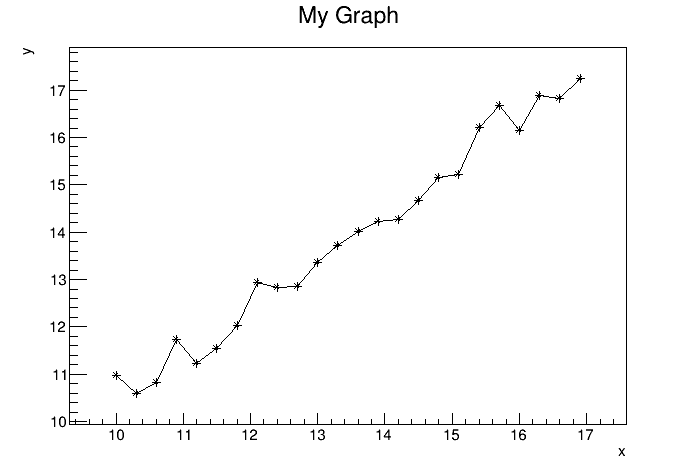

In [4]:
tg=r.TGraph(len(x),x,y)
tc=r.TCanvas()  # create a canvas to hold the plot
tg.SetTitle("My Graph;x;y")
tg.Draw("al*")  # draw the plot (on the active canvas)
tc.Draw()       # draw the canvas

The use of canvases may seem like unnecessary extra work, but this allows us to very easily manage multiple plot windows in a single program.

A big difference of the ROOT approach is that our plotting objects are also containers.  We can illustrade this by making the TGraph a different way.

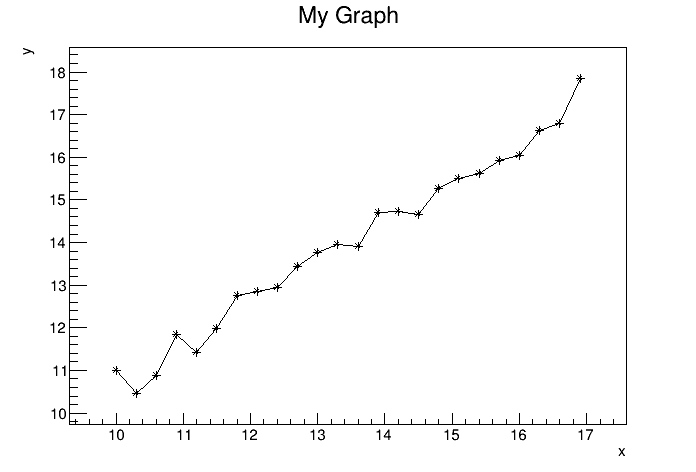

In [5]:
# Generate some random data with associated error bars.
ndata=24
xmin=10
xstep=0.3
rand=r.TRandom3()
tg=r.TGraph()
tg.SetTitle("My Graph;x;y")
for  i in range(ndata):
    xi = xmin + i*xstep
    yi = xi + rand.Uniform()
    tg.SetPoint(i,xi,yi)
tc=r.TCanvas()  # not really needed b/c tc already exists
tg.Draw("al*")
tc.Draw()

Add error bars
---

In Matplotlib, we can use the [errorbar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html) method to add errorbars.

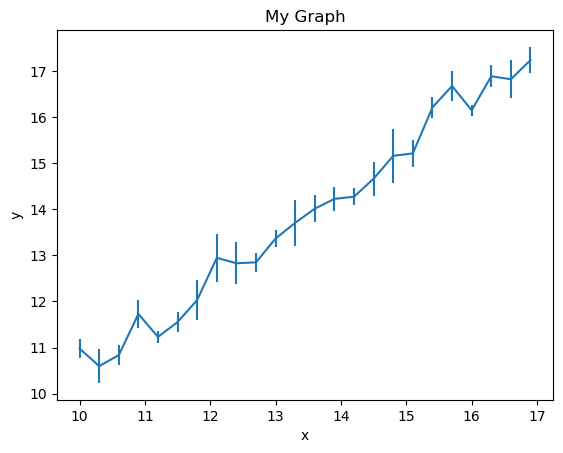

In [6]:
plt.title('My Graph')
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x,y,yerr=yerr);

The equivalent in ROOT is [TGraphErrors](https://root.cern.ch/doc/master/classTGraphErrors.html)

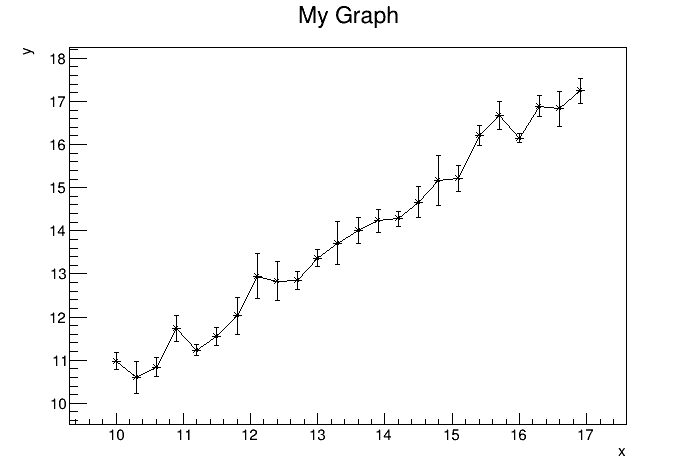

In [7]:
tge=r.TGraphErrors(len(x),x,y,0,yerr)
tge.SetTitle("My Graph;x;y")
tge.Draw("al*")
tc.Draw()

The 1D histogram
===

We frequesntly use 1D histograms dispay data distributions.  

Matplotlib [histograms](https://matplotlib.org/stable/gallery/statistics/hist.html)
---

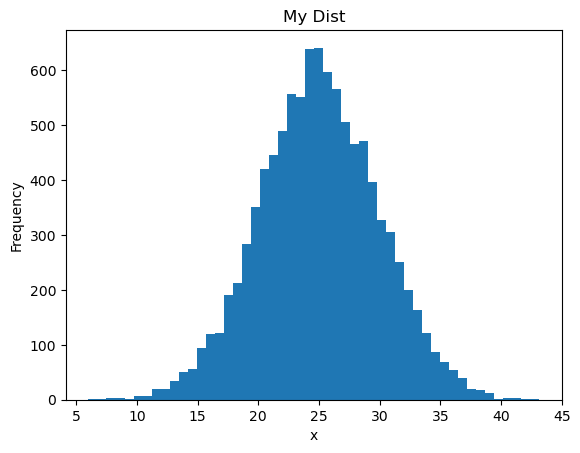

In [8]:
# Create a random number generator with a fixed seed for reproducibility
rng = np.random.default_rng(19680801)

N_points = 10000
n_bins = 50
mean=25
sigma=5

# Generate a normal distributions
dist = rng.standard_normal(N_points)*sigma+mean

# Set the number of bins with the *bins* keyword argument.
plt.title('My Dist')
plt.xlabel('x')
plt.ylabel('Frequency')
bins=plt.hist(dist, bins=n_bins);

ROOT [histograms](https://root.cern/manual/histograms/)
---

Histograms come in many flavors and dimensions in ROOT.  Here we will use the basic TH1F version.  This is a 1D histogram, where the contents of each bin is represented by a floating point number.  Other varieties exist, eg TH1D uses a double to represent bin content, TH1I uses an interger, etc.  

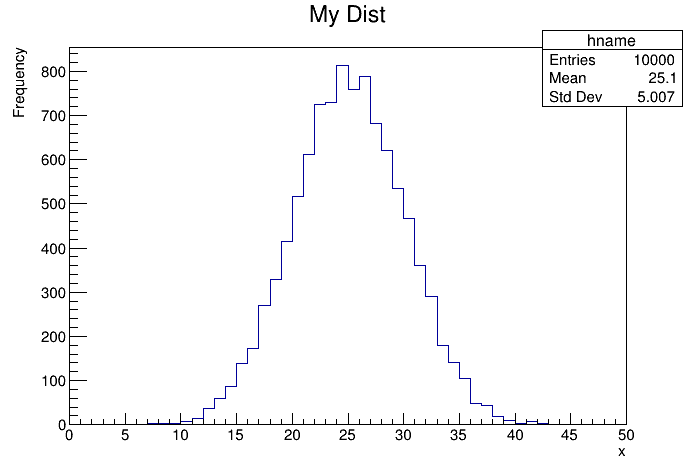

In [9]:
# Create a random number generator with a fixed seed for reproducibility
rand=r.TRandom3(123456)

N_points = 10000
n_bins = 50
mean=25
sigma=5
xmin=0
xmax=50

h=r.TH1F("hname","My Dist;x;Frequency",n_bins,xmin,xmax)  # create a hitogram

for i in range(N_points):   # fill this histogram
    val = rand.Gaus(mean,sigma)    
    h.Fill(val)
h.Draw()
tc.Draw()

Histograms with error bars
---
This is easy with ROOT.  Remember the plotting classes are containers, so they hold information about your data already.   

mean = 25.104828341969714
stddev = 5.0065205283571075


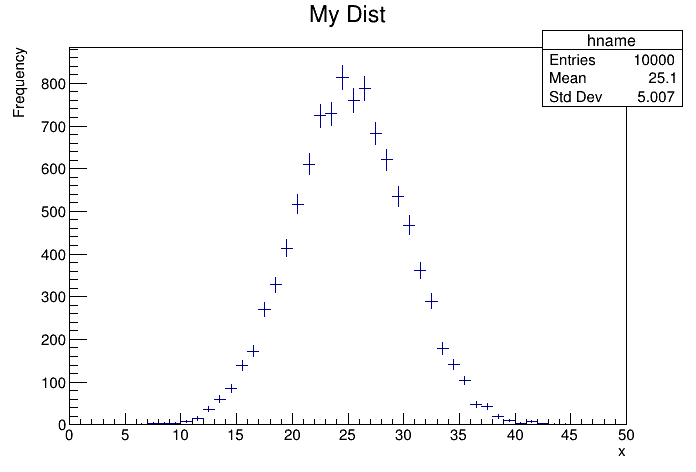

In [10]:
h.Draw("errors")  # or simply h.Draw("e")
tc.Draw()

print(f"mean = {h.GetMean()}")
print(f"stddev = {h.GetStdDev()}")


Now with Matplotlib.  Here we have to do all the calulcation for ourselves.  The hist method returns arrays with bin content and bin center, we can use these to calculate error bars.

mean = 25.00670383701274
stddev = 4.9277044966439165


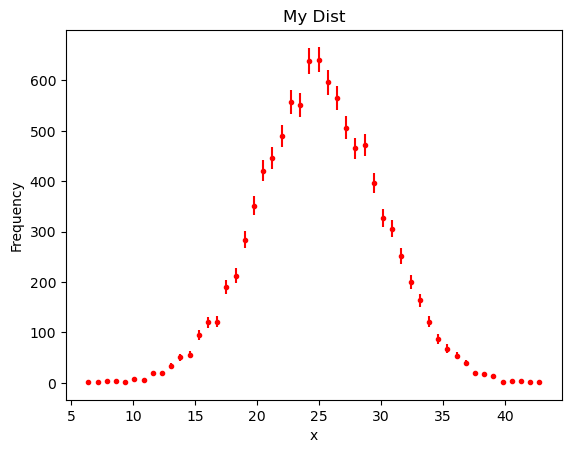

In [11]:
#bins=plt.hist(dist, bins=n_bins)
yb=bins[0]  # bin edges!
xb=bins[1]  # bin contents
err=np.sqrt(yb)
#Calculate bin centers (you can probably find a smarter way to do this!)
bc=(xb[1:]-xb[:-1])/2+xb[:-1]
plt.title('My Dist')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.errorbar(bc, yb, yerr=err, fmt=".", color="r")
print(f"mean = {np.mean(dist)}")
print(f"stddev = {np.std(dist)}")

Discussion
---

Storing your data in histograms can greatly reduce data volumes.  For example if you generated $10^{12}$ random numbers multiple times for different distributions, you really won't want to be dealing with these huge vectors more than you have to.  A histogram of 200 bins would only require 200 floats, etc to store the binned data!  You will of course have to remake histograms if you make changes to the distributions you plot.  

Exercise
===

There are endless varieties of plots that we can discuss.  This exercise will include a number of challenges for plotting data and distributions in a variety of ways.  The goal is to practice plot making and searching online documenation and examples to get more proficient at displaying data.  You may use either Matplot or ROOT.  You should discuss your approached with your classmates.  Complete your plots in the notebook cells below.

plotting 1d functions
---

Plot the functions sin(x), cos(x) over the domain [0:4*pi] on a single plot

In [12]:
# solution

Plot the functions sin(x), cos(x) over the domain [0:4*pi], but use two 'frames' such that the sign function is in the top frame and the cos function is in the bottom frame

In [13]:
# solution

plotting 2d functions 
---

plot the following function over the domain x: [-5:5] y: [-5:5]

$f(x,y) = -20.0 * exp(-0.2 * \sqrt{0.5 * (x^2 + y^2)}) - exp(0.5 * (cos(2 * pi * x) + cos(2 * pi * y))) + e + 20$

Here e is Euler's number = exp(1)

Use two plot panels.  In the upper panel display your plot as a color map.  In the lower panel display your plot as a lego plot.

In [14]:
# solution

1D histograms
---

Generate three sets of 1000 random numbers:
- set1 = Normal distribution with mean of 5.0 and stdev of sqrt(5)
- set2 = Poisson distribution with mean of 5.0
- set3 = binomial distribution for (n=10, p=0.5)

Display all of this histograms on a single plot.  Clearly labeling your data.

In [15]:
# solution

repeat with

- set1 = Normal distribution with mean of 10.0 and stdev of sqrt(10)
- set2 = Poisson distribution with mean of 10.0
- set3 = binomial distribution for (n=20, p=0.5)

Generate at least 10000 random numbers according to a Normal distribution the mean=100 and stdev=10.  Plot the results in  a histogram, then overlay the Normal distribution with your data.  Be careful to think about the correct noemallization of the Gaussian curve.  This will depend on the number of events you generate and the size of you bins.

In [16]:
# solution

Repeat, but show errors bars on your histogram

2D histograms
---

Generate a set of random bumners in pairs, according to the following:

- x_i is drawn from a Normal distribution with mean of 100, and sigma of 15, eg Gaussian(100,15)
- y_i = Gaussian (x_i,5), eg y is correlated with x

Make a 2d color map showing the density distribution.  Generate enough numbers to make the plot reasonably smooth.

Use two plot panels.  In the upper panel display your plot as a color map.  In the lower panel display your plot as a lego plot.

In [17]:
# solution